In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time, os
import dv_processing as dv
from PIL import Image
import numpy as np

In [61]:
def getRecordingDuration(record):
    if record.isEventStreamAvailable():
        start, end = record.getTimeRange()
        duration = end - start 
    
    return duration # divide by 1e6 to convert to seconds

def getSampleDuration(sample):
    start, end = sample.timestamps()[0], sample.timestamps()[-1]
    duration = end - start
    return duration

def getNumEvents(sample):
    num_events = sample.size()
    return num_events

def split_recording(record, batch_time, PRINT=False):
    record_duration = getRecordingDuration(record) # Total duration of recording
    resolution = record.getEventResolution() # Resolution of camera
    t0, t1 = record.getTimeRange() # Start & end timestamps of recording
    num_batches = record_duration // batch_time # Number of batches in recording (floored)

    if PRINT:
        print(f"Event resolution: {resolution}")
        print(f"Recording duration: {record_duration / 1e6} secs")
        print("Start timestamp:", t0)
        print("End timestamp:", t1)
    
    return (resolution, batch_time, num_batches, t0, t1)  # Return metadata

def get_batches(record, metadata):
    _, batch_time, num_batches, t0, _ = metadata # Unpacks metadata
    cols = ['batch', 't0', 't1', 'duration', 'num_events']
    batches = pd.DataFrame(columns=cols)
    start = t0
    for i in range(num_batches):
        start, end = start, start + batch_time
        batch = record.getEventsTimeRange(start, end)
        batch_duration = getSampleDuration(batch)
        batch_numEvents = getNumEvents(batch)

        data = pd.DataFrame({'batch': [i], 
                             't0': [start], 
                             't1': [end], 
                             'duration': [batch_duration], 
                             'num_events': [batch_numEvents]})
        batches = pd.concat([batches, data])
        start += batch_time

    return batches 

def get_batch_indices(df, batches, N, PRINT=False):
    num_events = batches['num_events'].iloc[N] # Gets Batch N 
    
    idx0 = batches['t0'].iloc[N]
    idx1 = batches['t1'].iloc[N]
    batch = df[(df['timestamp'] > idx0) & (df['timestamp'] < idx1)]
    # idxs = list(batch[batch['Unnamed: 0'] == 0].index)
    if PRINT:
        print(f"Number of events in Batch {N}: {num_events}")
    batch.reset_index(drop=True, inplace=True)
    return batch

def sample_2_image(sampleN, metadata):
    res, _, _, _, _ = metadata
    img = np.full(res, 1)
    for i in range(sampleN.shape[0]):
        x, y = sampleN['x'].iloc[i], sampleN['y'].iloc[i]
        img[x,y] = 0
    return img.T

def get_sample_freq_from_batch(batch, metadata, IMGS=False, PRINT=False):
    t0s = list(batch[batch['Unnamed: 0'] == 0].index)
    size = len(t0s)

    # Get # of events in each sample (gets sampling frequency)
    sample_freq = []
    imgs = []
    for i, t0 in enumerate(t0s):
        sample = batch.iloc[t0:t0s[i+1]] if i+1 < size else batch.iloc[t0:]
        sample_freq.append(sample.size)
        
        # Gets first image in first sample
        if IMGS:
            img = sample_2_image(sample, metadata)
            imgs.append(img)
            IMGS = False
            if PRINT: 
                print("# of events in first sample:", sample.size)

    sample_freq = np.array(sample_freq)
    
    if PRINT:
        print("# of samples in batch:", len(t0s))
        print("# of samples in batch (frequency check):", len(sample_freq))

    return sample_freq, np.array(imgs)

def plot_batches(batches, subject, letter):
    plt.clf()
    plt.bar(batches['batch'], batches['num_events'], color="tab:blue")
    plt.title(f"# of Events per Batch - Subject {subject} Letter {letter}")
    plt.xlabel("Batch")
    plt.ylabel("# of Events")
    
def plot_sample_freq(sample_freq, batchN):
    plt.clf()
    x = np.arange(len(sample_freq))
    plt.plot(x, sample_freq)
    # plt.scatter(x, sample_freq, marker='.')
    plt.xlabel("Sample")
    plt.ylabel("# of Events")
    plt.title(f"# of Events in Each Sample - Batch {batchN}")
    

In [30]:
# General settings
subject = 1
letter = 'f'
AEDAT = f"../data/aedat/subject{subject}/{letter}.aedat4"
CSV = f"../data/csv/subject{subject}/{letter}_events.csv"
TESTING = True

# Set time to split recording
batch_time = int(3e6) # Batch of 3 seconds worth of events

In [4]:
recording = dv.io.MonoCameraRecording(AEDAT) # Read in whole entire recording
metadata = split_recording(recording, batch_time, TESTING) # Track metadata - resolution, batch_size, num_batches, t0, t1
batches = get_batches(recording, metadata)
df = pd.read_csv(CSV) # Read entire CSV from converted AEDAT4.0 file

batches.iloc[:5] # Print first 5 rows of DataFrame

Event resolution: (240, 180)
Recording duration: 81.728724 secs
Start timestamp: 124288256
End timestamp: 206016980


,batch,t0,t1,duration,num_events
0,0,124288256,127288256,2999999,275695
0,1,127288256,130288256,2999848,360538
0,2,130288256,133288256,2999945,323390
0,3,133288256,136288256,2999980,315518
0,4,136288256,139288256,2999948,317157


Text(0, 0.5, 'Number of Events')

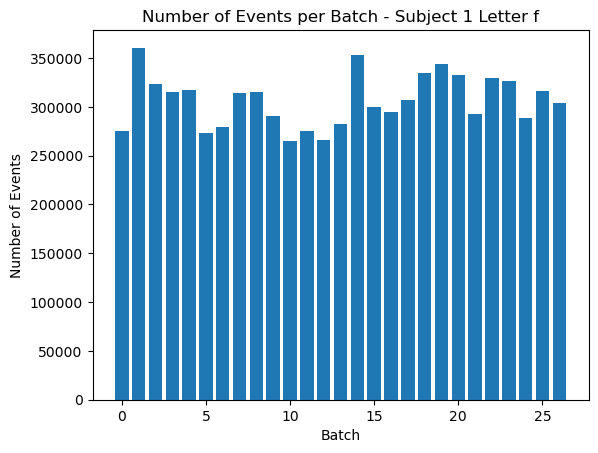

In [5]:
plt.bar(batches['batch'], batches['num_events'], color="tab:blue")
plt.title(f"Number of Events per Batch - Subject {subject} Letter {letter}")
plt.xlabel("Batch")
plt.ylabel("Number of Events")

Number of events in Batch 0: 275695


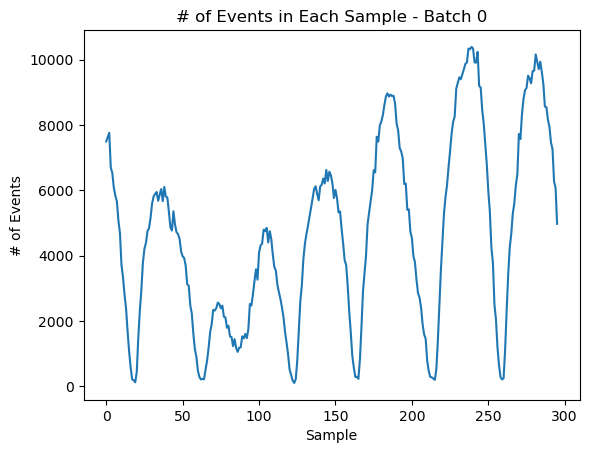

In [62]:
batchN = 0
batch = get_batch_indices(df, batches, batchN, TESTING)
sample_freqN, _ = get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)

Number of events in Batch 26: 304038


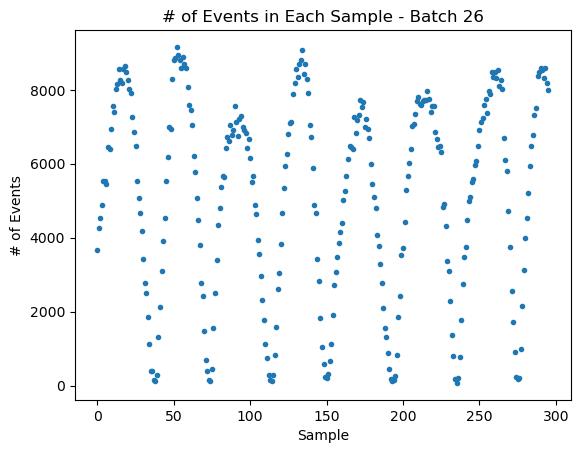

In [58]:
batchN = 26 # Toggle this to get another batch recording
batch = get_batch_indices(df, batches, batchN, TESTING)
sample_freqN, _ = get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)